# **Análisis Exploratorio de Datos (EDA)**

## **Librerías y modulos necesarios**

In [5]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from scipy import stats
from pandas.api.types import is_integer_dtype
warnings.filterwarnings("ignore")

## **Importación de datos**

Como se señaló en la sección de [contextualización](./contextualizacion.md), los datos utilizados provienen de la competencia [Give Me Some Credit](https://www.kaggle.com/competitions/GiveMeSomeCredit), desde donde pueden descargarse. Para facilitar el trabajo reproducible en este proyecto, hemos alojado los conjuntos de entrenamiento y prueba proporcionados por la competencia en el repositorio de GitHub [sePerezAlbor/Data](https://github.com/sePerezAlbor/Data), específicamente los archivos `GiveMeSomeCredit-cs-training.csv` y `GiveMeSomeCredit-cs-test.csv`. Para importar los datos se recomienza utilizar el siguiente código.

In [6]:
##### TRAINING DATA
url = "https://raw.githubusercontent.com/sePerezAlbor/Data/refs/heads/main/GiveMeSomeCredit-cs-training.csv"
train_data = pd.read_csv(url, na_values="NA", index_col=0)

##### TEST DATA
url = "https://raw.githubusercontent.com/sePerezAlbor/Data/refs/heads/main/GiveMeSomeCredit-cs-test.csv"
test_data = pd.read_csv(url, na_values="NA", index_col=0)

### **Renombrar columnas**

Esto es opcional y puede omitirse si se prefiere trabajar con los nombres de columnas originales.

In [7]:
train_data = train_data.rename(columns={
    'SeriousDlqin2yrs': 'mora_grave_2anios',
    'RevolvingUtilizationOfUnsecuredLines': 'utilizacion_lineas_credito',
    'age': 'edad',
    'NumberOfTime30-59DaysPastDueNotWorse': 'veces_mora_30_59_dias_2anios',
    'DebtRatio': 'razon_deuda_ingreso',
    'MonthlyIncome': 'ingreso_mensual',
    'NumberOfOpenCreditLinesAndLoans': 'num_creditos_lineas_abiertas',
    'NumberOfTimes90DaysLate': 'veces_mora_90_dias',
    'NumberRealEstateLoansOrLines': 'num_prestamos_inmobiliarios',
    'NumberOfTime60-89DaysPastDueNotWorse': 'veces_mora_60_89_dias_2anios',
    'NumberOfDependents': 'num_dependientes'
})

## **Diccionario de variables**

```{list-table} Diccionario de variables Give Me Some Credit
:header-rows: 1
:name: tabla-diccionario-gmsc

* - Variable
  - Variable Renombrada
  - Descripción
  - Tipo
* - `SeriousDlqin2yrs`
  - `mora_grave_2anios`
  - Persona con morosidad de 90 días o más.
  - Y/N
* - `RevolvingUtilizationOfUnsecuredLines`
  - `utilizacion_lineas_credito`
  - Saldo total de tarjetas de crédito y líneas de crédito personales, excepto bienes inmuebles y deudas sin cuotas fijas, como préstamos para automóviles, dividido por la suma de los límites de crédito.
  - percentage
* - `age`
  - `edad`
  - Edad del prestatario en años.
  - integer
* - `NumberOfTime30-59DaysPastDueNotWorse`
  - `veces_mora_30_59_dias_2anios`
  - Número de veces que el prestatario ha tenido un retraso de entre 30 y 59 días, pero sin agravarse, en los últimos dos años.
  - integer
* - `DebtRatio`
  - `razon_deuda_ingreso`
  - Pagos mensuales de deudas, pensión alimenticia y gastos de manutención divididos entre los ingresos mensuales.
  - percentage
* - `MonthlyIncome`
  - `ingreso_mensual`
  - Ingresos mensuales.
  - real
* - `NumberOfOpenCreditLinesAndLoans`
  - `num_creditos_lineas_abiertas`
  - Número de préstamos abiertos (préstamos a plazos, como préstamos para automóviles o hipotecas) y líneas de crédito (por ejemplo, tarjetas de crédito).
  - integer
* - `NumberOfTimes90DaysLate`
  - `veces_mora_90_dias`
  - Número de veces que el prestatario ha acumulado un retraso de 90 días o más en el pago.
  - integer
* - `NumberRealEstateLoansOrLines`
  - `num_prestamos_inmobiliarios`
  - Número de préstamos hipotecarios e inmobiliarios, incluidas las líneas de crédito con garantía hipotecaria.
  - integer
* - `NumberOfTime60-89DaysPastDueNotWorse`
  - `veces_mora_60_89_dias_2anios`
  - Número de veces que el prestatario ha tenido un retraso de entre 60 y 89 días, pero sin agravarse, en los últimos dos años.
  - integer
* - `NumberOfDependents`
  - `num_dependientes`
  - Número de personas a cargo en la familia, excluyéndose a sí mismos (cónyuge, hijos, etc.).
  - integer


## **Conjunto de datos**

In [8]:
train_data.head() 

,mora_grave_2anios,utilizacion_lineas_credito,edad,veces_mora_30_59_dias_2anios,razon_deuda_ingreso,ingreso_mensual,num_creditos_lineas_abiertas,veces_mora_90_dias,num_prestamos_inmobiliarios,veces_mora_60_89_dias_2anios,num_dependientes
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [9]:
train_data.shape

(150000, 11)

Se observa que las variables abarcan tanto características financieras como demográficas, incluyendo la edad del solicitante y el número de dependientes, así como múltiples indicadores relacionados con su comportamiento crediticio, tales como la utilización de líneas de crédito, la frecuencia de moras en distintos rangos de días, la relación deuda–ingreso, el ingreso mensual y el número de préstamos o líneas de crédito abiertas. Esta combinación de atributos, descritos en detalle en el [diccionario de variables Give Me Some Credit](tabla-diccionario-gmsc), proporciona una base integral para analizar patrones de riesgo y establecer relaciones entre factores personales y financieros que pueden influir en la probabilidad de morosidad grave. Ademas, se observa que el conjunto de datos contiene un total de 11 variables, incluyendo la variable objetivo `mora_grave_2anios`, y abarca 150.000 registros, lo que proporciona una base sólida para el análisis estadístico y la construcción de modelos predictivos.

## **Datos faltantes**


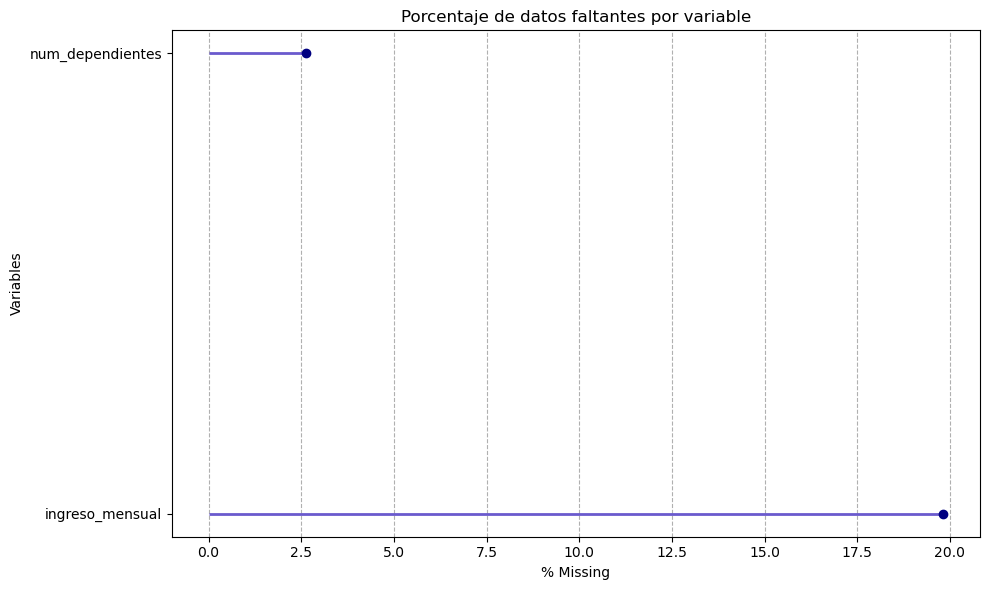

In [10]:
faltantes = train_data.isnull().mean().sort_values(ascending=False) * 100
faltantes = faltantes[faltantes > 0]

plt.figure(figsize=(10, 6))


plt.hlines(y=faltantes.index, xmin=0, xmax=faltantes.values, color='slateblue', linewidth=2)

plt.plot(faltantes.values, faltantes.index, "o", color='navy')

plt.xlabel('% Missing')
plt.ylabel('Variables')
plt.title('Porcentaje de datos faltantes por variable')

plt.grid(axis='x', linestyle='--')
plt.tight_layout()
plt.show()

El análisis de valores faltantes revela que las únicas variables con datos ausentes son `ingreso_mensual` y `num_dependientes`. La primera presenta 29731 registros sin información, equivalentes a un porcentaje cercano al 19.8 %, mientras que la segunda alcanza 3924 registros faltantes, aproximadamente un 2.6 %, por lo que será necesario imputarlas.


```{list-table} Estrategia de imputación
:header-rows: 1
:name: tabla-estrategia-imputacion

* - Columna
  - Porcentaje
  - Tipo de imputación
* - `num_dependientes`
  - 2.6 %
  - Imputación simple (mediana)
* - `ingreso_mensual`
  - 19.8 %
  - Imputación simple (mediana)
```

Esto se toma con base en [**Data Visualization in R**](https://rpubs.com/K-A-M/DataViz_R), donde se indica que:

* **Menos del 5 % de datos faltantes:** en general, no es necesario imputar, ya que la cantidad es pequeña y eliminar los registros con valores faltantes no afectará significativamente el análisis.
* **Entre 5 % y 20 % de datos faltantes:** se recomienda imputación simple, como media o mediana (para datos numéricos), moda o categoría más frecuente (para datos categóricos), o mediante regresión.

Sin embargo, dado que este es un ejercicio académico, se optará por imputar los valores faltantes incluso en el caso de porcentajes menores al 5 %, con el fin de conservar la totalidad de los registros para el análisis.


## **Imputación**

### **Imputacion de datos faltantes**

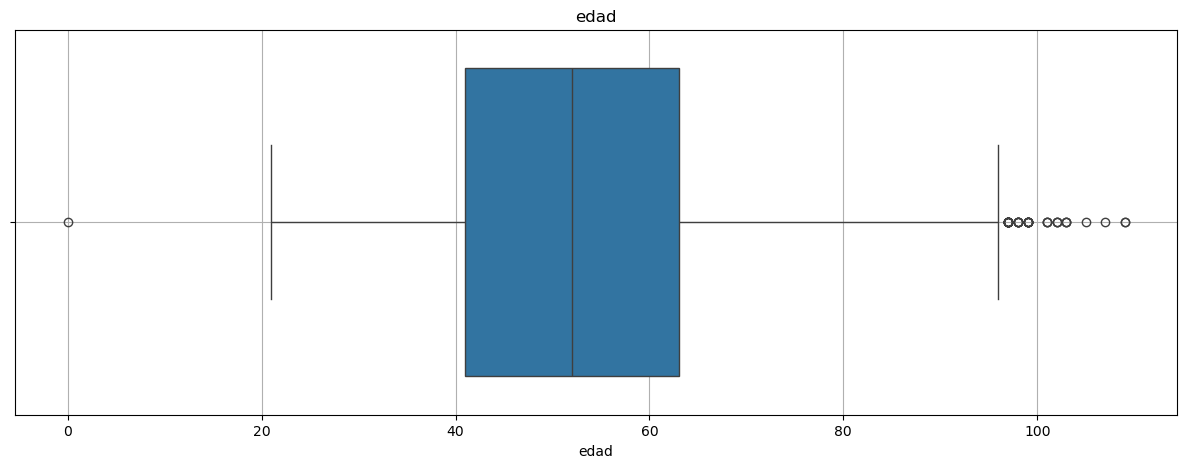

In [11]:
col_num_utiles = ['edad']
#print(col_num_utiles)

fig, ax = plt.subplots(nrows=1, ncols=len(col_num_utiles), figsize=(15, 5), gridspec_kw={'hspace': 0.5})

# Check if ax is a single object or an array
if len(col_num_utiles) > 1:
    for i, col in enumerate(col_num_utiles):
        sns.boxplot(x=train_data[col], ax=ax[i])
        ax[i].set_title(col)
else:
    sns.boxplot(x=train_data[col_num_utiles[0]], ax=ax)
    ax.set_title(col_num_utiles[0])

plt.grid(True)
plt.show()

In [12]:
# Filtrar las filas donde edad == 0
indices = train_data.index[train_data['edad'] == 0]

print(indices.tolist())

train_data.loc[indices]


[65696]


,mora_grave_2anios,utilizacion_lineas_credito,edad,veces_mora_30_59_dias_2anios,razon_deuda_ingreso,ingreso_mensual,num_creditos_lineas_abiertas,veces_mora_90_dias,num_prestamos_inmobiliarios,veces_mora_60_89_dias_2anios,num_dependientes
65696,0,1.0,0,1,0.436927,6000.0,6,0,2,0,2.0


In [13]:
edad = train_data['edad']

mu = edad.mean()
sigma = edad.std()
print(f"Media: {mu}")
print(f"Desviación estándar: {sigma}")

# Aplicar la prueba de Kolmogorov-Smirnov comparando con una normal N(mu, sigma)
ks_stat, p_value = stats.kstest(edad, 'norm', args=(mu, sigma), nan_policy='omit')

print(f"Estadístico KS: {ks_stat:.4f}")
print(f"Valor p: {p_value:.4e}")

# Interpretación
if p_value < 0.05:
    print("Rechazamos la hipótesis nula: la variable NO sigue una distribución normal.")
else:
    print("No se puede rechazar la hipótesis nula: la variable podría seguir una distribución normal.")

Media: 52.295206666666665
Desviación estándar: 14.77186586310081
Estadístico KS: 0.0326
Valor p: 1.6119e-138
Rechazamos la hipótesis nula: la variable NO sigue una distribución normal.


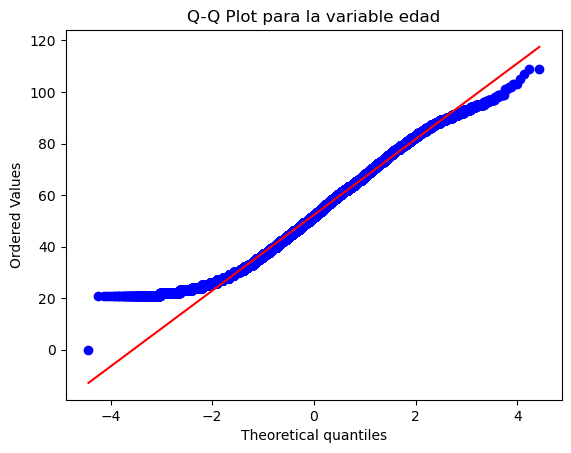

In [14]:
stats.probplot(edad, dist="norm", plot=plt)
plt.title("Q-Q Plot para la variable edad")
plt.show()

Evidentemente, la variable `edad` no sigue una distribución normal, por lo que realizaremos la imputación de ese registro en específico por la mediana.

In [15]:
# Calcular la mediana de la columna 'edad' (excluyendo ceros si es necesario)
mediana_edad = train_data.loc[train_data['edad'] != 0, 'edad'].median()

# Reemplazar valores 0 por la mediana
train_data.loc[indices, 'edad'] = mediana_edad

train_data.loc[indices]


,mora_grave_2anios,utilizacion_lineas_credito,edad,veces_mora_30_59_dias_2anios,razon_deuda_ingreso,ingreso_mensual,num_creditos_lineas_abiertas,veces_mora_90_dias,num_prestamos_inmobiliarios,veces_mora_60_89_dias_2anios,num_dependientes
65696,0,1.0,52,1,0.436927,6000.0,6,0,2,0,2.0


#### **Imputación de la variable** `num_dependientes`

Cantidad de datos faltantes para la variable num_dependientes: 3924

count    146076.000000
mean          0.757222
std           1.115086
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          20.000000
Name: num_dependientes, dtype: float64


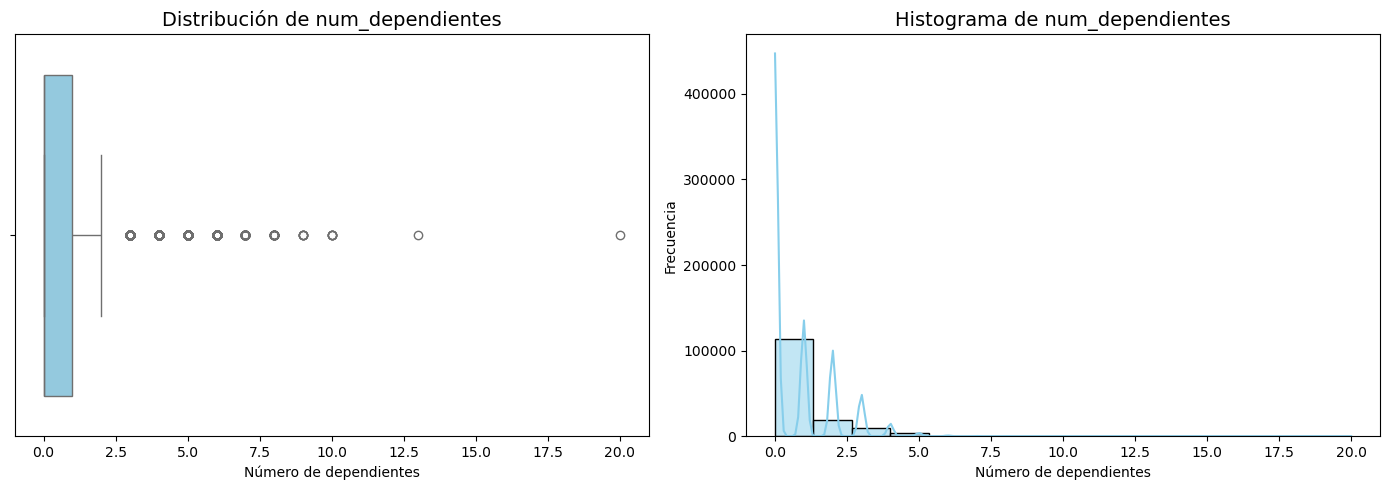

In [16]:
# Recuento de valores faltantes
faltantes = train_data['num_dependientes'].isna().sum()
print(f"Cantidad de datos faltantes para la variable num_dependientes: {faltantes}\n")
print(train_data['num_dependientes'].describe())

# Crear figura con dos subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot
sns.boxplot(
    x=train_data['num_dependientes'], 
    ax=axes[0],
    color="skyblue"
)
axes[0].set_title('Distribución de num_dependientes', fontsize=14)
axes[0].set_xlabel('Número de dependientes')

# Histograma
sns.histplot(
    train_data['num_dependientes'], 
    bins=15, 
    kde=True, 
    color="skyblue", 
    ax=axes[1]
)
axes[1].set_title('Histograma de num_dependientes', fontsize=14)
axes[1].set_xlabel('Número de dependientes')
axes[1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()


El análisis inicial de la variable `num_dependientes` revela una distribución con fuerte asimetría positiva, evidenciando que la mayoría de los solicitantes tienen pocos o ningún dependiente. La mediana es igual a 0 y los datos se concentran principalmente en valores bajos, aunque el diagrama de cajas y bigotes muestra la presencia de valores atípicos significativos, como un caso con 20 dependientes, que se encuentra muy alejado del rango habitual. Este tipo de registros puede distorsionar medidas estadísticas y afectar el desempeño de los modelos predictivos, por lo que será necesario implementar un tratamiento adecuado de outliers antes de la fase de modelado.


#### **Segmentación por edades**

  grupo_edad_ndependientes  mean_dependents  median_dependents  non_null_count
0                    18-30         0.333107                0.0           10327
1                    31-50         1.170353                1.0           58690
2                    51-70         0.591297                0.0           60621
3                      71+         0.160543                0.0           16438


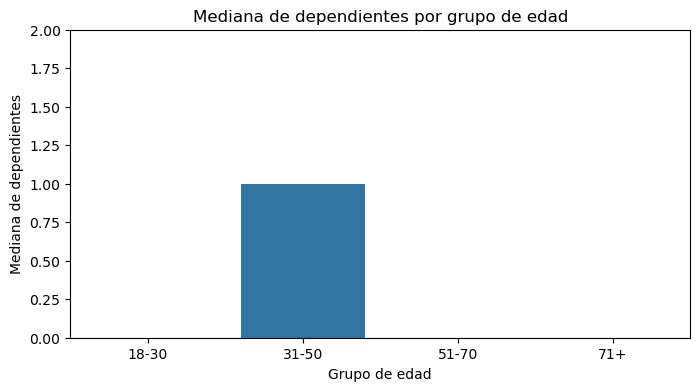

In [17]:
depend_col = 'num_dependientes'  # Use the column name as a string

# --- 2) Asegurar tipos numéricos
train_data[depend_col] = pd.to_numeric(train_data[depend_col], errors='coerce')
train_data['edad'] = pd.to_numeric(train_data['edad'], errors='coerce')

# --- 3) Definir grupos de edad 18-30, 31-50, 51-70, 71+
max_age = int(train_data['edad'].dropna().max())
bins = [17, 30, 50, 70, max_age + 1]      # uso 17 y max+1 para incluir 18..30, 31..50, ...
labels = ['18-30', '31-50', '51-70', '71+']
train_data['grupo_edad_ndependientes'] = pd.cut(train_data['edad'], bins=bins, labels=labels, right=True)

# --- 4) Calcular media, mediana y conteo
group_stats = train_data.groupby('grupo_edad_ndependientes')[depend_col].agg(
    mean_dependents = 'mean',
    median_dependents = 'median',
    non_null_count = 'count'   # cuenta valores no nulos de dependientes por grupo
).reset_index()

# Mostrar resultados
print(group_stats)

# --- 5) Gráfico para visualizar la MEDIANA
plt.figure(figsize=(8,4))
sns.barplot(data=group_stats, x='grupo_edad_ndependientes', y='median_dependents')
plt.title('Mediana de dependientes por grupo de edad')
plt.xlabel('Grupo de edad')
plt.ylabel('Mediana de dependientes')
plt.ylim(0, max(group_stats['median_dependents'].dropna()) + 1)
plt.show()


La gráfica muestra la **mediana** del número de dependientes en cada grupo de edad definido:

* **18–30 años:** mediana de **0 dependientes**.
* **31–50 años:** mediana de **1 dependiente**.
* **51–70 años:** mediana de **0 dependientes**.
* **71+ años:** mediana de **0 dependientes**.


In [18]:
depend_col = 'num_dependientes'

# 1) Medianas por grupo (redondeadas) — usar observed=True para quitar warning
group_medians = (train_data
                 .groupby('grupo_edad_ndependientes', observed=True)[depend_col]
                 .median()
                 .round()
                 .astype('Int64'))
print("Medianas por grupo (redondeadas):")
print(group_medians)

# 2) Imputación vectorizada sobre la misma columna
median_map = group_medians.to_dict()
faltantes = train_data[depend_col].isna()

# Imputar usando la mediana por grupo
train_data.loc[faltantes, depend_col] = train_data.loc[faltantes, 'grupo_edad_ndependientes'].map(median_map)

# (Opcional) si quedan NaN porque grupo_edad_ndependientes es NaN, imputar con mediana global
if train_data[depend_col].isna().any():
    med_global = train_data[depend_col].median().round()
    train_data[depend_col] = train_data[depend_col].fillna(med_global)

# 3) Comprobaciones
print("\nValores faltantes después de la imputación:", train_data[depend_col].isna().sum())

# 4) Conteo de imputaciones por grupo
imputed_counts = (train_data.loc[faltantes]
                  .groupby('grupo_edad_ndependientes', observed=True)
                  .size())
print("\nNúmero de imputaciones por grupo:")
print(imputed_counts)


Medianas por grupo (redondeadas):
grupo_edad_ndependientes
18-30    0
31-50    1
51-70    0
71+      0
Name: num_dependientes, dtype: Int64

Valores faltantes después de la imputación: 0

Número de imputaciones por grupo:
grupo_edad_ndependientes
18-30     430
31-50     686
51-70    1610
71+      1198
dtype: int64


#### **Imputación de la variable** `ingreso_mensual`

Cantidad de datos faltantes para la variable Ingreso Mensual: 29731

count    1.202690e+05
mean     6.670221e+03
std      1.438467e+04
min      0.000000e+00
25%      3.400000e+03
50%      5.400000e+03
75%      8.249000e+03
max      3.008750e+06
Name: ingreso_mensual, dtype: float64


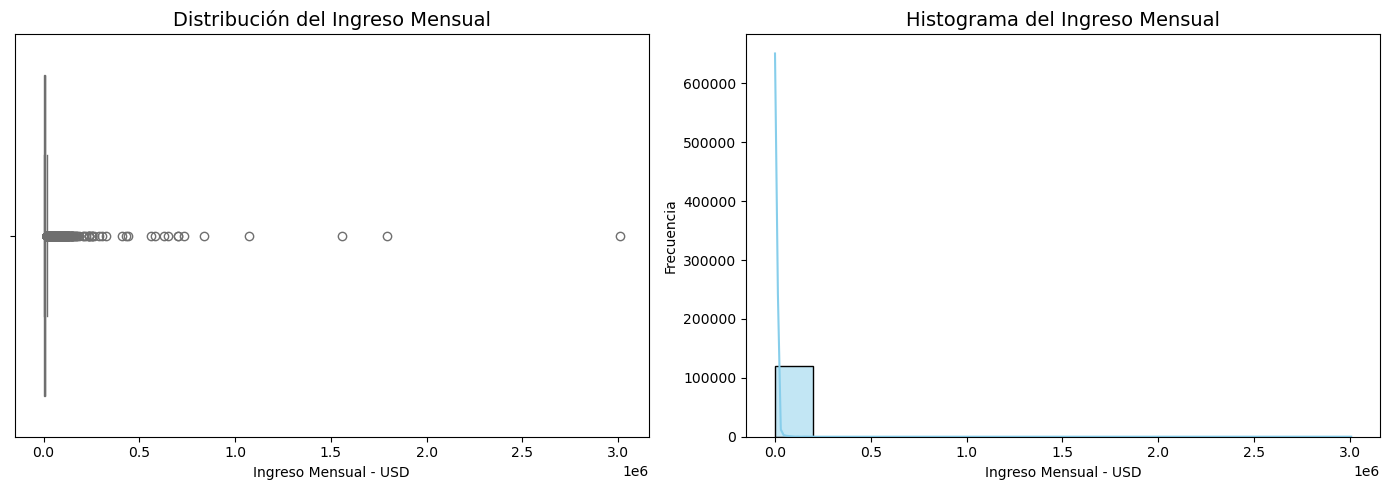

In [19]:
# Recuento de valores faltantes
faltantes = train_data['ingreso_mensual'].isna().sum()
print(f"Cantidad de datos faltantes para la variable Ingreso Mensual: {faltantes}\n")
print(train_data['ingreso_mensual'].describe())

# Crear figura con dos subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot
sns.boxplot(
    x=train_data['ingreso_mensual'],
    ax=axes[0],
    color="skyblue"
)
axes[0].set_title('Distribución del Ingreso Mensual', fontsize=14)
axes[0].set_xlabel('Ingreso Mensual - USD')

# Histograma
sns.histplot(
    train_data['ingreso_mensual'],
    bins=15,
    kde=True,
    color="skyblue",
    ax=axes[1]
)
axes[1].set_title('Histograma del Ingreso Mensual', fontsize=14)
axes[1].set_xlabel('Ingreso Mensual - USD')
axes[1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()


In [20]:
print(train_data['ingreso_mensual'].min())
print(train_data['ingreso_mensual'].max())

0.0
3008750.0


Los gráficos obtenidos anteriormente se deben a la presencia de valores atípicos muy extremos, cómo podemos obervar el **valor mínimo de esta variable es 0 USD** y el **máximo 3'008'750 USD**. Para solucionar este problema y apreciar mejor el comportamiento de las variables veamos ambos gráficos sin estos datos atípicos

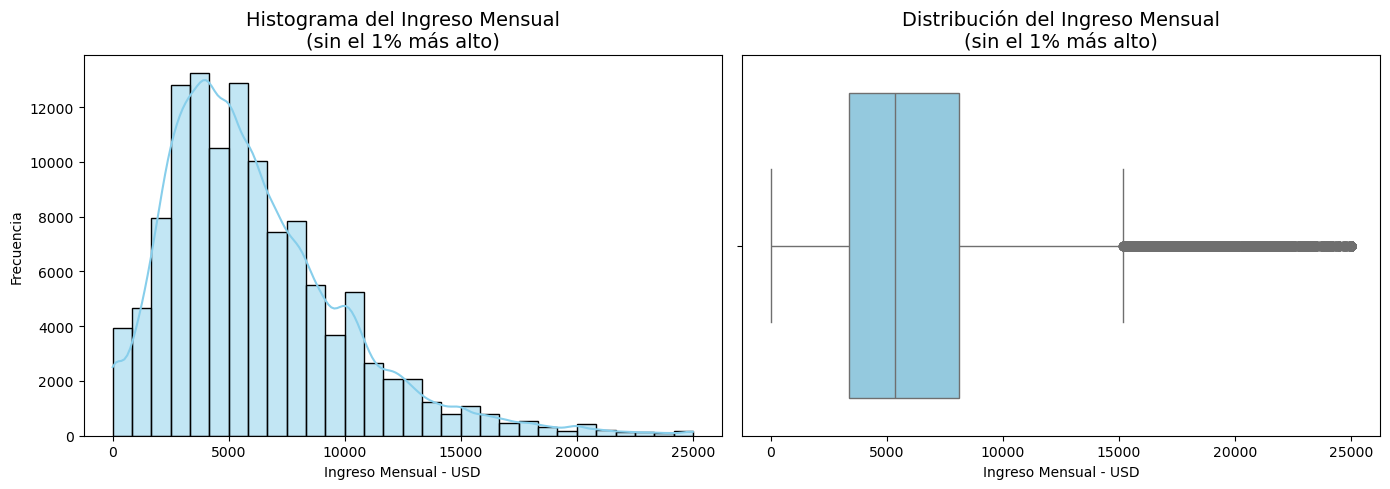

In [21]:
# Filtrar sin el 1% más alto
limite_superior = train_data['ingreso_mensual'].quantile(0.99)
data_filtrada = train_data[train_data['ingreso_mensual'] <= limite_superior]['ingreso_mensual']

# Crear figura con dos subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma
sns.histplot(data_filtrada, bins=30, kde=True, color="skyblue", ax=axes[0])
axes[0].set_title('Histograma del Ingreso Mensual\n(sin el 1% más alto)', fontsize=14)
axes[0].set_xlabel('Ingreso Mensual - USD')
axes[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=data_filtrada, color="skyblue", ax=axes[1])
axes[1].set_title('Distribución del Ingreso Mensual\n(sin el 1% más alto)', fontsize=14)
axes[1].set_xlabel('Ingreso Mensual - USD')

plt.tight_layout()
plt.show()


Evidentemente, la variable `ingreso_mensual` tampoco es simétrica en su distribución, sino que presenta un sesgo hacia la derecha. Con el objetivo de corroborar esta hipótesis (que no sigue una distribución Normal) apliquemos una prueba analítica.

In [22]:
ingreso = train_data['ingreso_mensual']

mu = ingreso.mean()
sigma = ingreso.std()
print(f"Media: {mu}")
print(f"Desviación estándar: {sigma}")

# Aplicar la prueba de Kolmogorov-Smirnov comparando con una normal N(mu, sigma)
ks_stat, p_value = stats.kstest(edad, 'norm', args=(mu, sigma), nan_policy='omit')

print(f"Estadístico KS: {ks_stat:.4f}")
print(f"Valor p: {p_value:.4e}")

# Interpretación
if p_value < 0.05:
    print("Rechazamos la hipótesis nula: la variable NO sigue una distribución normal.")
else:
    print("No se puede rechazar la hipótesis nula: la variable podría seguir una distribución normal.")

Media: 6670.221237392844
Desviación estándar: 14384.674215282244
Estadístico KS: 0.6760
Valor p: 0.0000e+00
Rechazamos la hipótesis nula: la variable NO sigue una distribución normal.


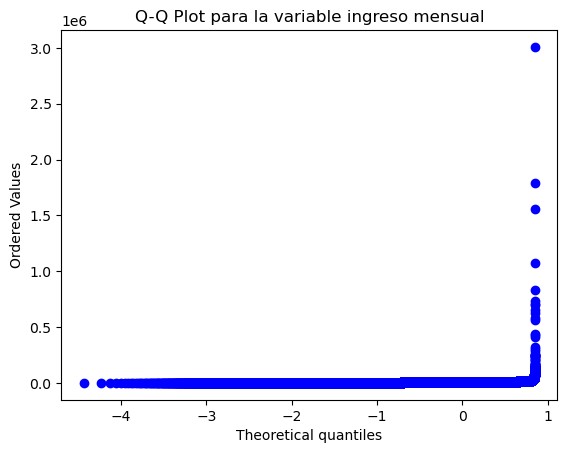

In [23]:
stats.probplot(ingreso, dist="norm", plot=plt)
plt.title("Q-Q Plot para la variable ingreso mensual")
plt.show()

Evidentemente, la variable ingreso mensual no sigue una distribución normal. Y, debido a la **cantidad de datos faltantes** (aproximadamente el 20%) tendremos que hacer una imputación a través de técnicas válidas

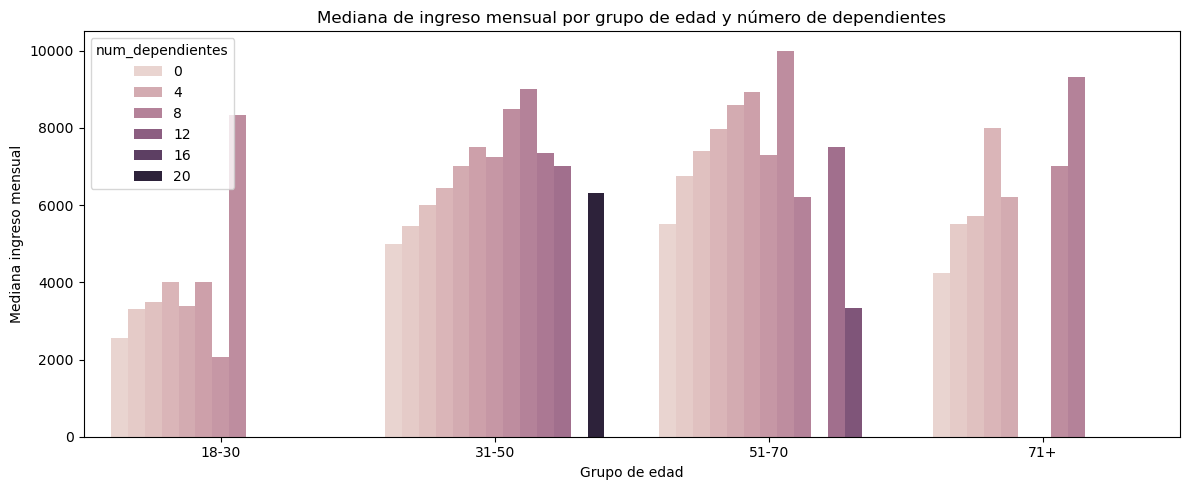

In [24]:
# Crear grupos etarios
bins = [17, 30, 50, 70, np.inf]
labels = ['18-30', '31-50', '51-70', '71+']
train_data['grupo_edad_ingresom'] = pd.cut(train_data['edad'], bins=bins, labels=labels)

# Mediana por (grupo_edad, num_dependientes)
medianas_df = (
    train_data
    .groupby(['grupo_edad_ingresom', 'num_dependientes'], observed=True)['ingreso_mensual']
    .median()
    .reset_index(name='mediana_ingreso')
)

# Gráfica: mediana de ingreso por grupo etario (hue = num_dependientes)
plt.figure(figsize=(12,5))
sns.barplot(data=medianas_df, x='grupo_edad_ingresom', y='mediana_ingreso', hue='num_dependientes')
plt.title('Mediana de ingreso mensual por grupo de edad y número de dependientes')
plt.xlabel('Grupo de edad')
plt.ylabel('Mediana ingreso mensual')
plt.tight_layout()
plt.show()


La gráfica muestra la mediana del ingreso mensual segmentada por grupo de edad y número de dependientes.
Se observa que, dentro de cada grupo de edad, la mediana de ingreso tiende a variar en función del número de dependientes, presentando en algunos casos valores más altos para ciertos niveles de dependientes. Además, la dispersión de medianas es diferente entre grupos etarios, con algunos mostrando mayor rango de ingresos que otros.


In [25]:
# Crear mapa (grupo_edad, num_dependientes) -> mediana_ingreso
medianas_map = medianas_df.set_index(['grupo_edad_ingresom', 'num_dependientes'])['mediana_ingreso']

# Imputación vectorizada usando merge (rápida y clara)
train_data = train_data.merge(
    medianas_df, how='left',
    on=['grupo_edad_ingresom', 'num_dependientes']
)

# Rellenar faltantes con la mediana segmentada
mask_na = train_data['ingreso_mensual'].isna()
train_data.loc[mask_na, 'ingreso_mensual'] = train_data.loc[mask_na, 'mediana_ingreso']

# Si aún quedan NaN (combinaciones sin datos), usar mediana global
if train_data['ingreso_mensual'].isna().any():
    mediana_global = train_data['ingreso_mensual'].median()
    train_data['ingreso_mensual'] = train_data['ingreso_mensual'].fillna(mediana_global)

# Limpiar columna auxiliar
train_data.drop(columns='mediana_ingreso', inplace=True)


La gráfica muestra la mediana del ingreso mensual segmentada por grupo de edad y número de dependientes.
Se observa que, dentro de cada grupo de edad, la mediana de ingreso tiende a variar en función del número de dependientes, presentando en algunos casos valores más altos para ciertos niveles de dependientes. Además, la dispersión de medianas es diferente entre grupos etarios, con algunos mostrando mayor rango de ingresos que otros.

In [26]:
train_data = train_data.drop(['grupo_edad_ndependientes', 'grupo_edad_ingresom'], axis=1)  

In [27]:
train_data.isnull().sum()

mora_grave_2anios               0
utilizacion_lineas_credito      0
edad                            0
veces_mora_30_59_dias_2anios    0
razon_deuda_ingreso             0
ingreso_mensual                 0
num_creditos_lineas_abiertas    0
veces_mora_90_dias              0
num_prestamos_inmobiliarios     0
veces_mora_60_89_dias_2anios    0
num_dependientes                0
dtype: int64

Después de aplicar las estrategias de imputación definidas mediana por grupo para `num_dependientes` y mediana segmentada por grupo de edad y número de dependientes para `ingreso_mensual`, se eliminó por completo la presencia de valores faltantes en el conjunto de datos, asegurando que todas las variables relevantes estén listas para las fases de análisis y modelado.


Text(0.5, 1.0, 'Distribución de Mora Grave a 2 Años')

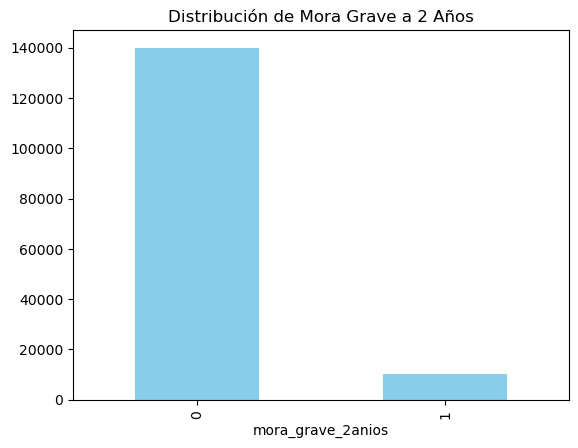

In [28]:
train_data['mora_grave_2anios'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribución de Mora Grave a 2 Años')

### **Imputación de valores a tipicos**

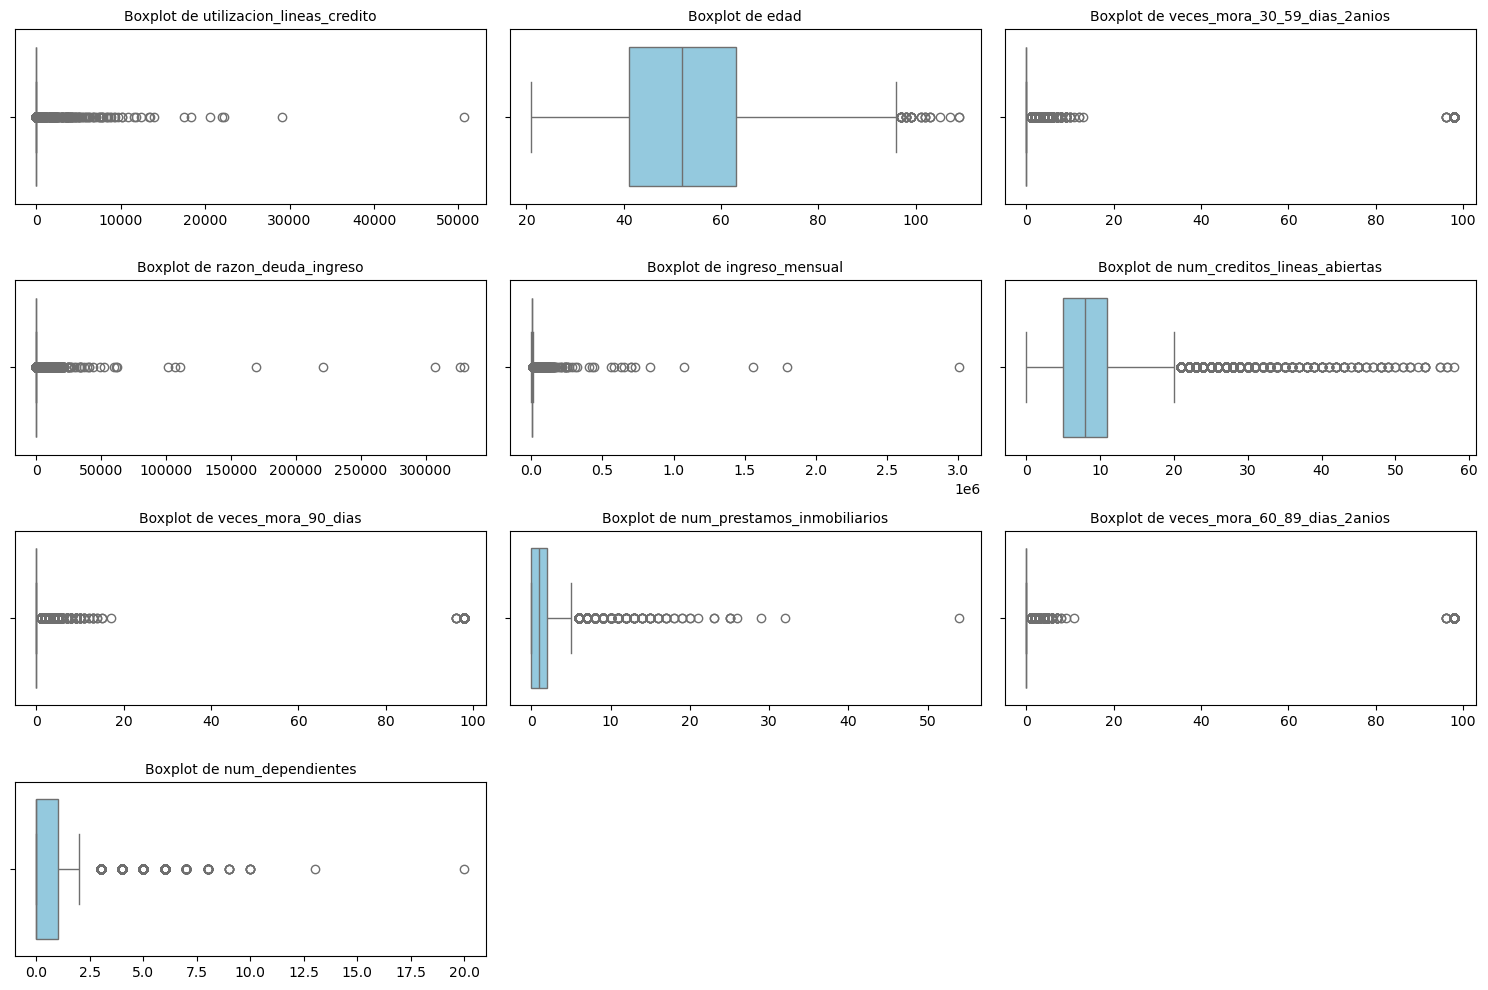

In [29]:
# Excluir la variable objetivo
columnas = [col for col in train_data.columns if col != 'mora_grave_2anios']

# Calcular el número de filas y columnas para los subplots
n_cols = 3  # cantidad de gráficos por fila
n_rows = math.ceil(len(columnas) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 2.5))
axes = axes.flatten()

for i, col in enumerate(columnas):
    sns.boxplot(x=train_data[col], color='skyblue', ax=axes[i])
    axes[i].set_title(f'Boxplot de {col}', fontsize=10)
    axes[i].set_xlabel('')

# Ocultar ejes vacíos si sobran
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Los boxplots muestran la distribución y los valores atípicos (*outliers*) de cada variable numérica (excepto `mora_grave_2anios`).
En casi todas las variables se observan valores extremos muy alejados del rango intercuartílico (IQR), lo que indica alta dispersión y posibles registros anómalos.

* Variables como `utilizacion_lineas_credito`, `razon_deuda_ingreso` e `ingreso_mensual` presentan outliers de gran magnitud, con rangos que se extienden considerablemente hacia valores altos.
* En `edad`, la dispersión es más controlada, pero aún se identifican casos por encima de los 100 años.
* Las variables de morosidad (`veces_mora_30_59_dias_2anios`, `veces_mora_60_89_dias_2anios`, `veces_mora_90_dias`) tienen una concentración en valores bajos, pero con unos pocos casos extremos muy altos.
* `num_creditos_lineas_abiertas` y `num_prestamos_inmobiliarios` muestran patrones similares, con la mayoría de observaciones en rangos bajos y algunos valores muy elevados.
* `num_dependientes` está concentrada en pocos dependientes, con algunos casos aislados que superan los 10 y un máximo cercano a 20.

En conjunto, la gráfica revela que varias variables tienen distribuciones asimétricas y con presencia importante de outliers que podrían requerir tratamiento previo al modelado.


In [30]:
def tratar_outliers(df, columnas, force_int_cols=('num_dependientes','veces_mora_30_59_dias_2anios')):
    df_limpio = df.copy()

    for col in columnas:
        serie = df_limpio[col].dropna()
        if len(serie) == 0:
            continue

        Q1, Q3 = serie.quantile(0.25), serie.quantile(0.75)
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
        porcentaje = ((serie < lower) | (serie > upper)).mean() * 100

        # --- Caso A: winsorización (porcentaje < 15) ---
        if porcentaje < 15:
            if is_integer_dtype(df_limpio[col].dtype) or col in force_int_cols:
                lower_i, upper_i = np.floor(lower), np.ceil(upper)
                df_limpio[col] = df_limpio[col].clip(lower=lower_i, upper=upper_i).round().astype('int64')
            else:
                df_limpio[col] = df_limpio[col].clip(lower=lower, upper=upper)

        # --- Caso B: porcentaje >= 15 ---
        else:
            if col in force_int_cols:
                # Para columnas que deben seguir siendo enteras, NO aplicar log: winsorizar igual
                lower_i, upper_i = np.floor(lower), np.ceil(upper)
                df_limpio[col] = df_limpio[col].clip(lower=lower_i, upper=upper_i).round().astype('int64')
            else:
                # Solo log-transform si no negativa
                if (df_limpio[col].dropna() >= 0).all():
                    df_limpio[col] = np.log1p(df_limpio[col].astype('float64'))


    for c in force_int_cols:
        if c in df_limpio.columns:
            df_limpio[c] = pd.to_numeric(df_limpio[c], errors='coerce').round().astype('int64')

    return df_limpio

In [31]:
columnas_numericas = [
    c for c in train_data.select_dtypes(include=[np.number]).columns
    if c != 'mora_grave_2anios'
]

train_data_orig = train_data.copy()
train_data = tratar_outliers(train_data, columnas_numericas)

```{list-table} Tecnicas de tratamiento de outliers
:header-rows: 1
:name: example-table

* - Variable
  - Outliers
  - Porcentaje
  - Acción
* - utilizacion_lineas_credito
  - 543
  - 0.45 %
  - Winsorización aplicada
* - edad
  - 118
  - 0.10 %
  - Winsorización aplicada
* - veces_mora_30_59_dias_2anios
  - 20,299
  - 16.88 %
  - Winsorización aplicada (forzada por tipo entero)
* - razon_deuda_ingreso
  - 7,358
  - 6.12 %
  - Winsorización aplicada
* - ingreso_mensual
  - 4,879
  - 4.06 %
  - Winsorización aplicada
* - num_creditos_lineas_abiertas
  - 3,472
  - 2.89 %
  - Winsorización aplicada
* - veces_mora_90_dias
  - 6,725
  - 5.59 %
  - Winsorización aplicada
* - num_prestamos_inmobiliarios
  - 680
  - 0.57 %
  - Winsorización aplicada
* - veces_mora_60_89_dias_2anios
  - 6,275
  - 5.22 %
  - Winsorización aplicada
* - num_dependientes
  - 232
  - 0.19 %
  - Winsorización aplicada
```

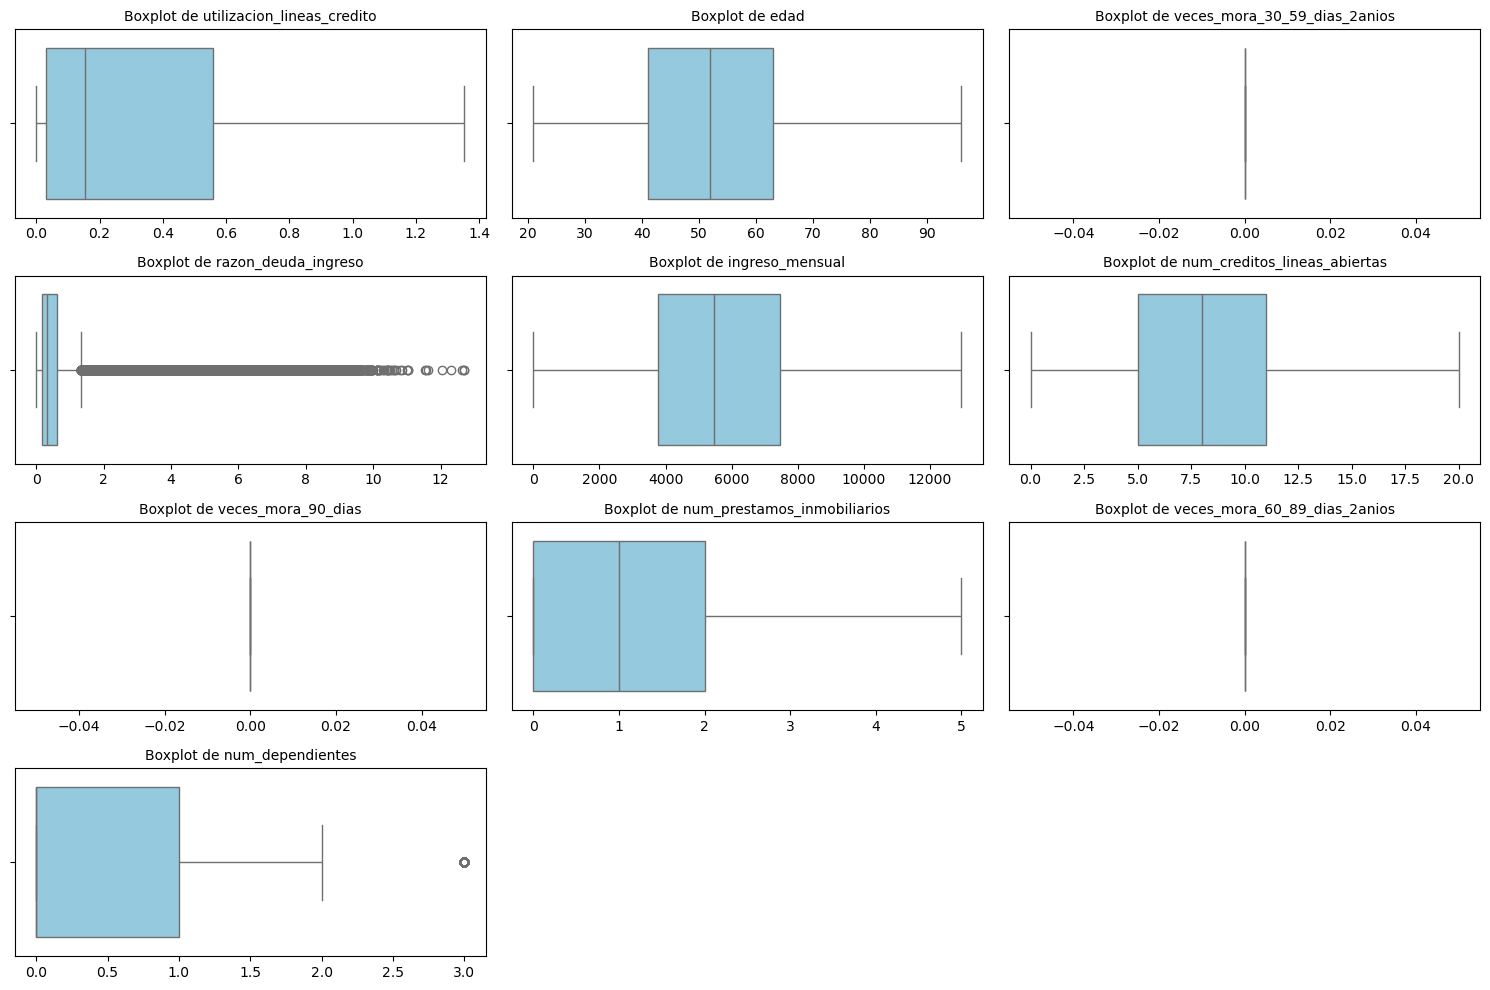

In [32]:
# Excluir la variable objetivo
columnas = [col for col in train_data.columns if col != 'mora_grave_2anios']

# Calcular el número de filas y columnas para los subplots
n_cols = 3  # cantidad de gráficos por fila
n_rows = math.ceil(len(columnas) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 2.5))
axes = axes.flatten()

for i, col in enumerate(columnas):
    sns.boxplot(x=train_data[col], color='skyblue', ax=axes[i])
    axes[i].set_title(f'Boxplot de {col}', fontsize=10)
    axes[i].set_xlabel('')

# Ocultar ejes vacíos si sobran
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Después de realizar el tratamiento de outliers, se aplicó una **winsorización** a las variables numéricas, lo que implica reemplazar los valores extremos por los percentiles 1 y 99. Esta técnica permite reducir el impacto de los valores atípicos sin eliminar completamente los registros, manteniendo así la integridad del conjunto de datos:

* **utilizacion\_lineas\_credito:** valores concentrados en la parte baja (mediana ≈ 0.2) y cola a la derecha; tope visual \~1.4.
* **edad:** distribución bastante simétrica; mediana \~50–55, IQR \~40–60, extremos \~20 y \~95.
* **veces\_mora\_30\_59\_dias\_2anios / 60\_89 / 90\_dias:** cajas casi en **0**; la mayoría no tiene moras registradas y la dispersión es mínima.
* **razon\_deuda\_ingreso:** sigue con cola derecha alargada; quedan observaciones altas aisladas.
* **ingreso\_mensual:** asimetría moderada; mediana \~5–6k, IQR \~4–7.5k, máximos alrededor de 13k.
* **num\_creditos\_lineas\_abiertas:** mediana \~9–10, IQR \~6–11; algunos casos llegan \~20.
* **num\_prestamos\_inmobiliarios:** mediana \~1, IQR \~0–2; límite superior \~5.
* **num\_dependientes:** mediana **0**; la mayoría entre 0–1 y pocos casos en **3** como puntos aislados.

En conjunto: varias variables mantienen **sesgo positivo**, pero los rangos extremos quedaron acotados; las de morosidad están **altamente concentradas en 0**.


In [33]:
col = 'razon_deuda_ingreso'
s = train_data[col].astype(float)

x = np.log1p(s)
Q1, Q3 = x.quantile([0.25, 0.75]); IQR = Q3 - Q1
low, high = np.expm1(Q1 - 1.5*IQR), np.expm1(Q3 + 1.5*IQR)
low = max(low, 0.0)                     # ratio no negativo
antes = s.copy()
train_data[col] = s.clip(lower=low, upper=high)
print(f"[Log-IQR]    Recortados: {(train_data[col] != antes).mean()*100:.2f}% | límites=({low:.4g}, {high:.4g})")


[Log-IQR]    Recortados: 19.90% | límites=(0, 1.69)


Debido a que la variable `razon_deuda_ingreso` aún contiene una gran cantidad de datos **atípicos**, aplicamos una **winsorización por IQR en escala logarítmica**: transformamos la variable con `log1p`, calculamos Q1, Q3 e IQR, obtuvimos los umbrales \$Q1 - 1.5 \cdot IQR\$ y \$Q3 + 1.5 \cdot IQR\$ en esa escala y los revertimos con `expm1` (forzando el **límite** inferior a 0). Luego, recortamos la variable con `clip` a esos límites. Este procedimiento atenúa la **cola derecha** y reduce el impacto de observaciones extremas, **sin eliminar registros** ni alterar la parte central de la distribución, dejando el conjunto listo para el modelado.


Text(0.5, 1.0, 'Boxplot de Razon Deuda Ingreso')

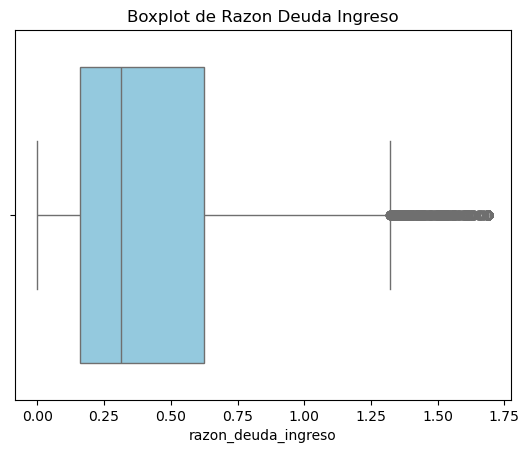

In [34]:
sns.boxplot(x=train_data['razon_deuda_ingreso'], color='skyblue')
plt.title('Boxplot de Razon Deuda Ingreso')

La distribución de `razon_deuda_ingreso` queda **concentrada en valores bajos** (mediana alrededor de 0.3) y mantiene **cola a la derecha** tras el tratamiento: aún hay algunos valores altos (≥1). Estos casos son plausibles implican que los pagos de deuda mensual **superan el ingreso** (sobreendeudamiento, intereses/acumulaciones), así que **los conservaremos tal cual** y no aplicaremos más recorte.


## **Análisis de variables**

Ya inputadas las variables, se procede a realizar un análisis exploratorio de los datos (EDA) para identificar patrones, tendencias y relaciones entre las variables. Este proceso es fundamental para comprender la estructura del conjunto de datos y preparar el terreno para la construcción de modelos predictivos.

### **Distribución de la variable objetivo**

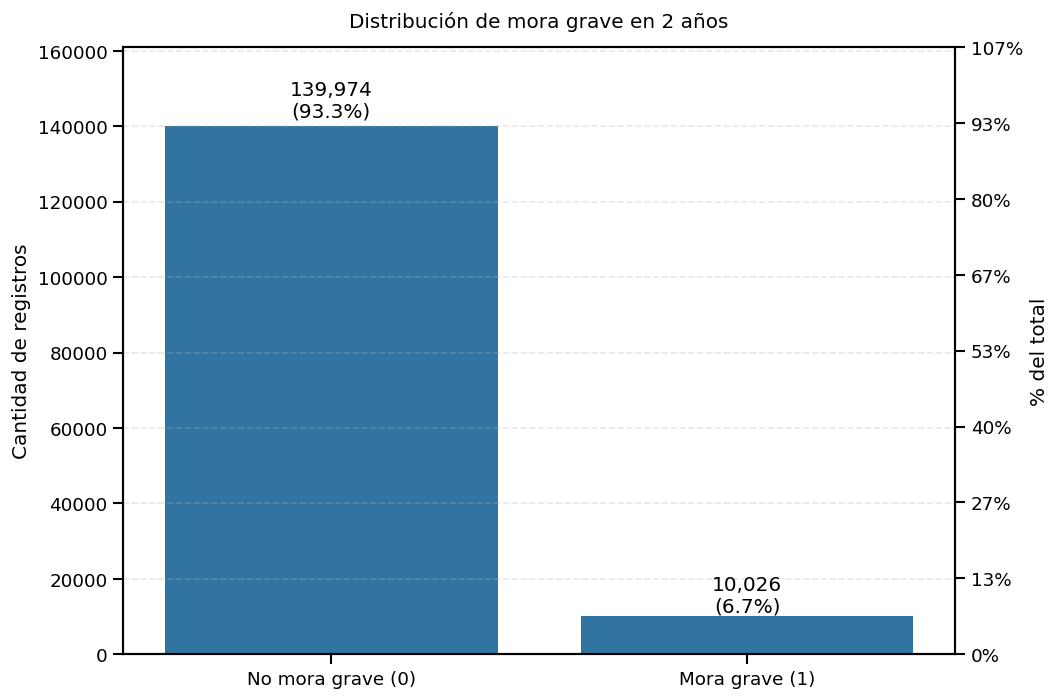

In [35]:
sns.set_context("notebook")  # 'paper' < 'notebook' < 'talk' < 'poster'

counts = train_data['mora_grave_2anios'].value_counts().sort_index()
pct = counts / counts.sum() * 100
plot_df = pd.DataFrame({'clase':[0,1], 'count': counts.values, 'pct': pct.values})
etiquetas = {0: 'No mora grave (0)', 1: 'Mora grave (1)'}

fig, ax = plt.subplots(figsize=(9,6), dpi=120)  # <-- más grande
sns.barplot(data=plot_df, x='clase', y='count', ax=ax)

ax.set_xticklabels([etiquetas[c] for c in plot_df['clase']])

# Etiquetas arriba con más separación y fuente mayor
for i, row in plot_df.iterrows():
    ax.text(i, row['count']*1.01,              # 1% por encima de la barra
            f"{int(row['count']):,}\n({row['pct']:.1f}%)",
            ha='center', va='bottom', fontsize=12)

# Eje secundario en %
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
yt = ax.get_yticks()
total = counts.sum()
ax2.set_yticks(yt)
ax2.set_yticklabels([f"{(y/total*100):.0f}%" for y in yt])
ax2.set_ylabel('% del total')

ax.set_title('Distribución de mora grave en 2 años', pad=12)
ax.set_xlabel('')
ax.set_ylabel('Cantidad de registros')
ax.grid(axis='y', linestyle='--', alpha=.3)
ax.margins(y=0.15)  # más espacio superior

plt.tight_layout()
plt.show()


La gráfica muestra un **fuerte desbalance de clases**: **139,974** casos (≈**93.3%**) **no** presentan mora grave en 2 años y **10,026** casos (≈**6.7%**) **sí** presentan mora grave. En otras palabras, el evento positivo es minoritario, por lo que cualquier modelado deberá tener en cuenta este desbalance.


### **Análisis de correlación**

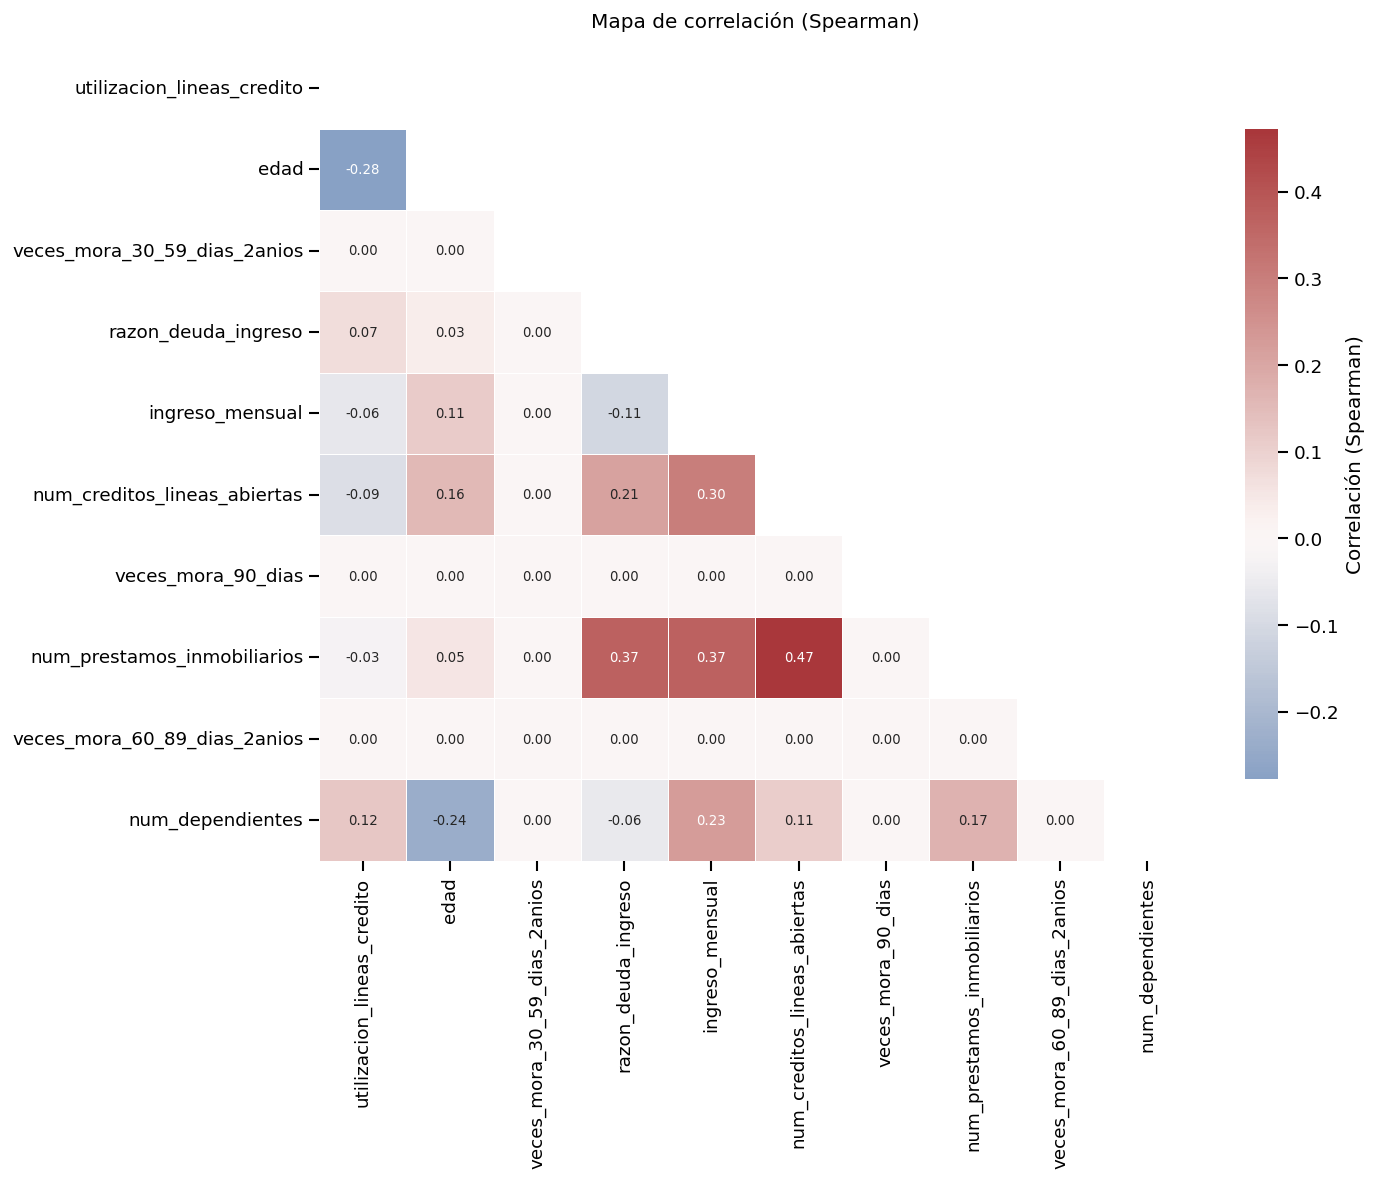

In [36]:
# --- Configuración ---
target = 'mora_grave_2anios'   # cámbialo si tu objetivo tiene otro nombre
excluir_target = True          # pon False si quieres incluirla en el mapa
metodo = 'spearman'            # 'pearson' | 'spearman' | 'kendall'

# --- Selección de columnas numéricas ---
num_cols = train_data.select_dtypes(include=[np.number]).columns.tolist()
if excluir_target and target in num_cols:
    num_cols.remove(target)

# --- Matriz de correlación ---
corr = train_data[num_cols].corr(method=metodo).fillna(0)  # <- mostrar 0 en lugar de NaN

# --- Heatmap (triángulo inferior) ---
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(12, 10), dpi=120)
sns.heatmap(
    corr, mask=mask, cmap='vlag', center=0,
    annot=True, fmt=".2f", annot_kws={"size":8},
    linewidths=.5, cbar_kws={"shrink": .8, "label": f"Correlación ({metodo.title()})"}
)
plt.title(f"Mapa de correlación ({metodo.title()})", pad=12)
plt.tight_layout()
plt.show()


La correlación entre las variables numéricas, donde se destacan las correlaciones más altas y más bajas:

**Más altas (absolutas):**

* `num_prestamos_inmobiliarios` \~ `num_creditos_lineas_abiertas`: **0.47** (relación positiva clara).
* `num_prestamos_inmobiliarios` \~ `ingreso_mensual`: **0.37** (a mayor ingreso, suelen aparecer más préstamos inmobiliarios).
* `num_prestamos_inmobiliarios` \~ `razon_deuda_ingreso`: **0.37** (más préstamos inmobiliarios se asocian con mayor razón deuda/ingreso).

**Más bajas (prácticamente nulas):**

* `utilizacion_lineas_credito` \~ `veces_mora_30_59_dias_2anios`: **0.00**.
* `utilizacion_lineas_credito` \~ `veces_mora_60_89_dias_2anios`: **0.00**.
* `utilizacion_lineas_credito` \~ `veces_mora_90_dias`: **0.00**.

En resumen: hay asociaciones moderadas alrededor de los préstamos inmobiliarios, y relaciones casi inexistentes entre utilización de crédito y las variables de mora por días.

## **Regresión logística**

In [ ]:
X = train_data.drop(columns=['mora_grave_2anios'])
y = train_data['mora_grave_2anios']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y
)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [76]:
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9296
AUC-ROC: 0.775248474634097

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96     27995
           1       0.25      0.03      0.05      2005

    accuracy                           0.93     30000
   macro avg       0.59      0.51      0.51     30000
weighted avg       0.89      0.93      0.90     30000



El modelo base alcanza una **accuracy de 0.9296**, cifra elevada pero claramente influida por el **desbalance de clases** (la clase 0 domina el conjunto). La métrica prioritaria en la competencia es el **AUC-ROC**, donde obtiene **0.7752**, lo que indica capacidad razonable para **ordenar** los casos por riesgo. No obstante, con el umbral por defecto (0.5) el modelo **casi no identifica morosos**: la clase 1 presenta **precisión 0.25**, **recall 0.03** y **F1 0.05**. En consecuencia, el trabajo se enfocará en **optimizar el AUC** tal como exige la competencia y, en paralelo, en **mitigar el desbalance** y **ajustar el umbral** con base en las curvas ROC/PR, para **mejorar la detección de morosos** sin perder el objetivo principal.


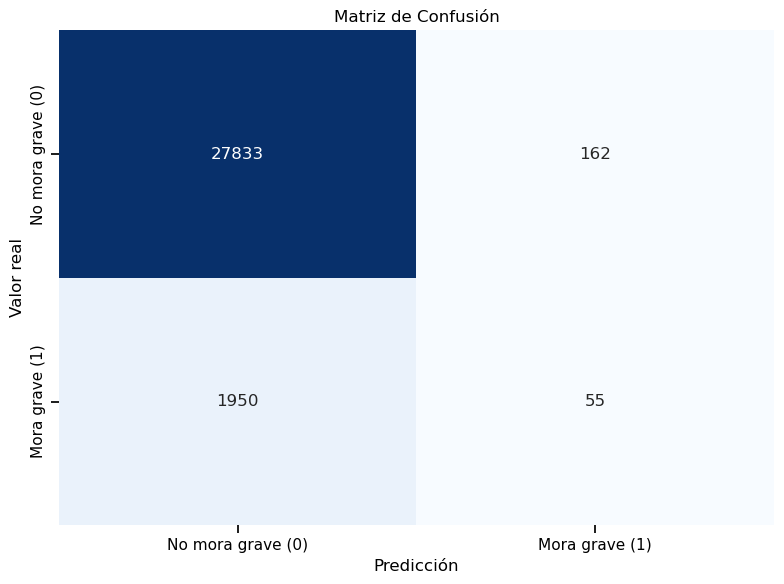

In [81]:
cm = confusion_matrix(y_test, y_pred)
labels = ['No mora grave (0)', 'Mora grave (1)']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.tight_layout()
plt.show()


La matriz de confusión muestra un modelo muy sesgado hacia la clase **0**:

* **TN = 27,833** y **FP = 162** → excelente **especificidad** (\~99.4%), casi no etiqueta como moroso a quien no lo es.
* **TP = 55** y **FN = 1,950** → **recall** de la clase 1 \~**2.7%** (55/2005): el modelo **casi no detecta morosos**.
* Exactitud = (27,833+55)/30,000 ≈ **92.96%**, pero está inflada por el desbalance.
La matriz de confusión muestra un modelo muy sesgado hacia la clase **0**.
